RNCP38616 – Bloc 03

C1 : Sélectionnez l'algorithme d'apprentissage le plus adapté en comparant les performances et les caractéristiques des différentes familles d'algorithmes



C2 : Préparer et transformer des données en utilisant des techniques de prétraitement pour les adapter aux spécificités du modèle d'apprentissage automatique choisi


C3 : Entraîner un modèle d'apprentissage automatique en optimisant une fonction de perte à partir des données d'entraînement




# 1.chargement des librairies

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modèles scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor





# 2. chargement de la données affichage des 5 premieres lignes

In [6]:
#  Chargement des données
fichier = "personas_assurance.csv"
df = pd.read_csv(fichier)
# Afficher les premières lignes
df.head()


,client_id,age,situation_familiale,statut_logement,type_logement,surface_m2,region,patrimoine_estime,revenu_annuel,assureur,garanties,exclusions,nombre_garanties,montant_couvert,cotisation_annuelle,sinistres_déclarés,dernier_sinistre,résiliation_précédente,paiements_en_retard
0,CLT00001,74,Veuf(ve),Propriétaire,Maison mitoyenne,123,Provence-Alpes-Côte d'Azur,39360,26504,"Covéa (MMA, MAAF, GMF)","['Attentats matériels', 'Responsabilité civile...","['Incendie, foudre, explosion, vandalisme', 'D...",3,36901,1637,3,2025-02-19,Oui,Non
1,CLT00002,23,En couple,Propriétaire,Appartement,83,Auvergne-Rhône-Alpes,24900,51971,"Covéa (MMA, MAAF, GMF)","['Catastrophes naturelles', 'Responsabilité ci...",['Vol'],2,10408,748,2,2025-01-14,Non,Non
2,CLT00003,32,Divorcé(e),Propriétaire,Maison mitoyenne,150,Provence-Alpes-Côte d'Azur,48000,28716,Matmut,"['Catastrophes naturelles', 'Attentats matérie...",['Vol'],3,34769,1152,1,2024-03-27,Non,Non
3,CLT00004,36,Divorcé(e),Propriétaire,Appartement,49,Auvergne-Rhône-Alpes,14700,39057,"Covéa (MMA, MAAF, GMF)",['Attentats matériels'],"['Tempête, grêle, neige']",1,5075,378,2,2022-10-20,Non,Non
4,CLT00005,54,Célibataire,Propriétaire,Appartement,77,Nouvelle-Aquitaine,23870,48385,Macif (Aéma Groupe),['Catastrophes naturelles'],['Assistance'],1,19728,443,1,2025-03-24,Oui,Non


# 3. Vérification de la données et valeurs manquantes

In [7]:
# types et des valeurs manquantes
types_df = pd.DataFrame({
    'Type': df.dtypes,
    'Non nuls': df.notnull().sum(),
    'Total': len(df)
})
missing_df = pd.DataFrame({
    'Valeurs manquantes': df.isnull().sum()
})
summary = types_df.join(missing_df)
print("\nRésumé des colonnes :")
print(summary)



Résumé des colonnes :
                          Type  Non nuls  Total  Valeurs manquantes
client_id               object      5000   5000                   0
age                      int64      5000   5000                   0
situation_familiale     object      5000   5000                   0
statut_logement         object      5000   5000                   0
type_logement           object      5000   5000                   0
surface_m2               int64      5000   5000                   0
region                  object      5000   5000                   0
patrimoine_estime        int64      5000   5000                   0
revenu_annuel            int64      5000   5000                   0
assureur                object      5000   5000                   0
garanties               object      5000   5000                   0
exclusions              object      5000   5000                   0
nombre_garanties         int64      5000   5000                   0
montant_couvert          

# 4 . Visualisation par graphique des variable numérique 

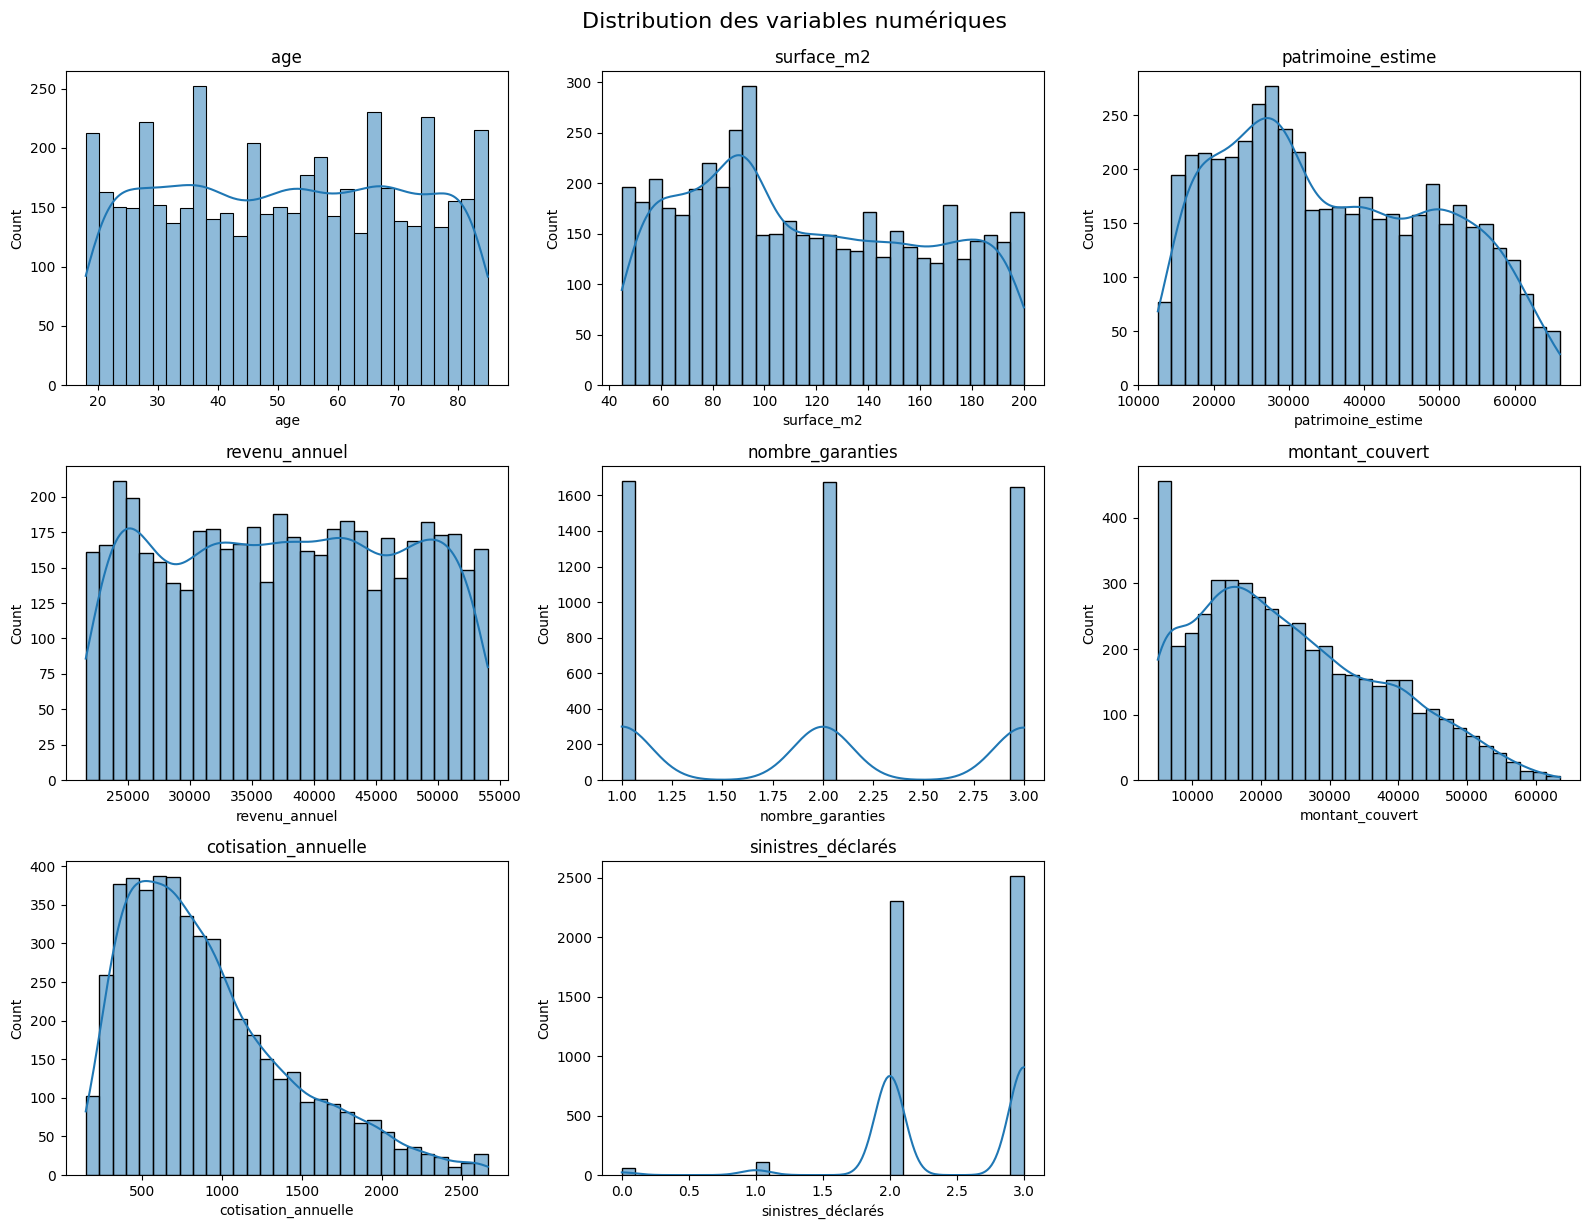

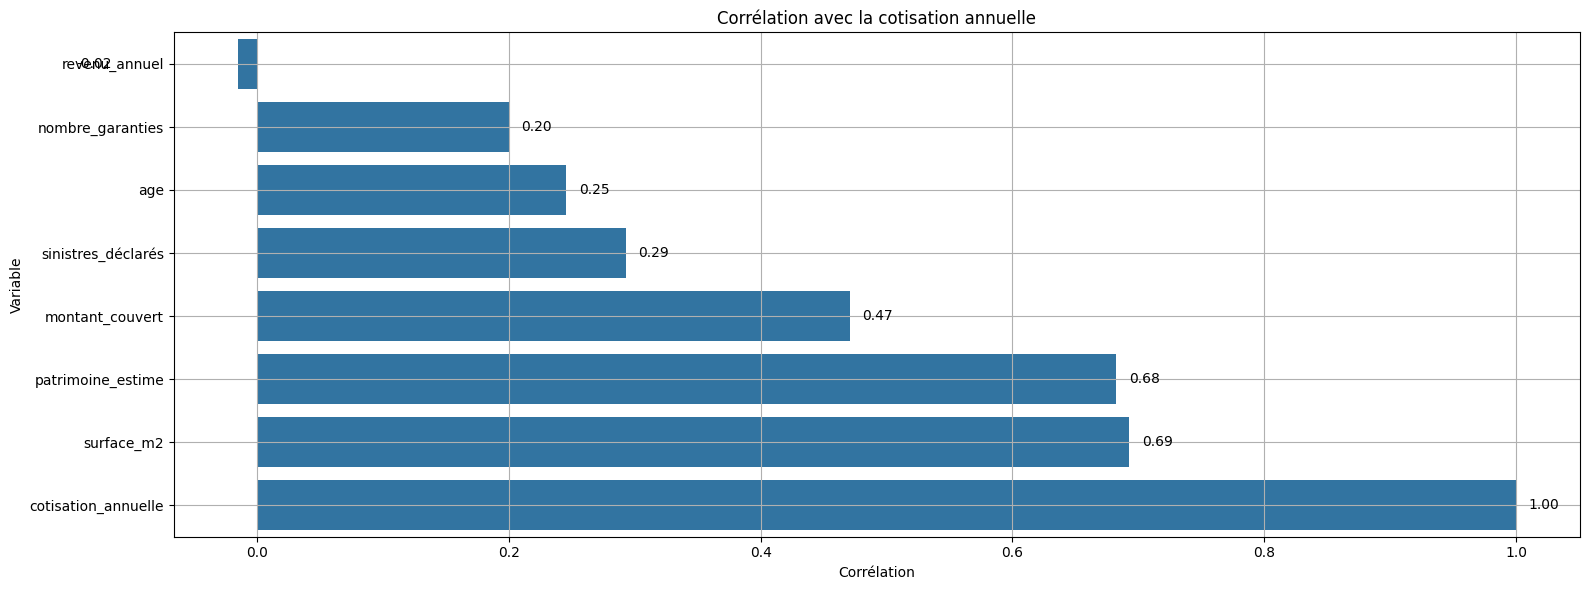

In [8]:

# Liste des colonnes numériques
num_cols = [
    'age', 'surface_m2', 'patrimoine_estime', 'revenu_annuel',
    'nombre_garanties', 'montant_couvert', 'cotisation_annuelle',
    'sinistres_déclarés'
]

#  Histogrammes des variables numériques
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
    plt.tight_layout()
plt.suptitle("Distribution des variables numériques", fontsize=16, y=1.02)
plt.show()

#  Corrélations avec la cotisation annuelle des variables numériques
correlations = df[num_cols].corr()['cotisation_annuelle'].sort_values()
correlations_df = correlations.reset_index()
correlations_df.columns = ['Variable', 'Corrélation']

plt.figure(figsize=(16, 6))
ax = sns.barplot(x='Corrélation', y='Variable', data=correlations_df)
plt.title("Corrélation avec la cotisation annuelle")
plt.xlabel("Corrélation")
plt.grid(True)

#  Ajouter la valeur sur chaque barre
for i, (corr, var) in enumerate(zip(correlations_df['Corrélation'], correlations_df['Variable'])):
    ax.text(corr + 0.01 if corr >= 0 else corr - 0.1, i, f"{corr:.2f}", va='center', ha='left' if corr >= 0 else 'right')

plt.tight_layout()
plt.show()


# 5. Visualisation par graphique des variable catégorielle 

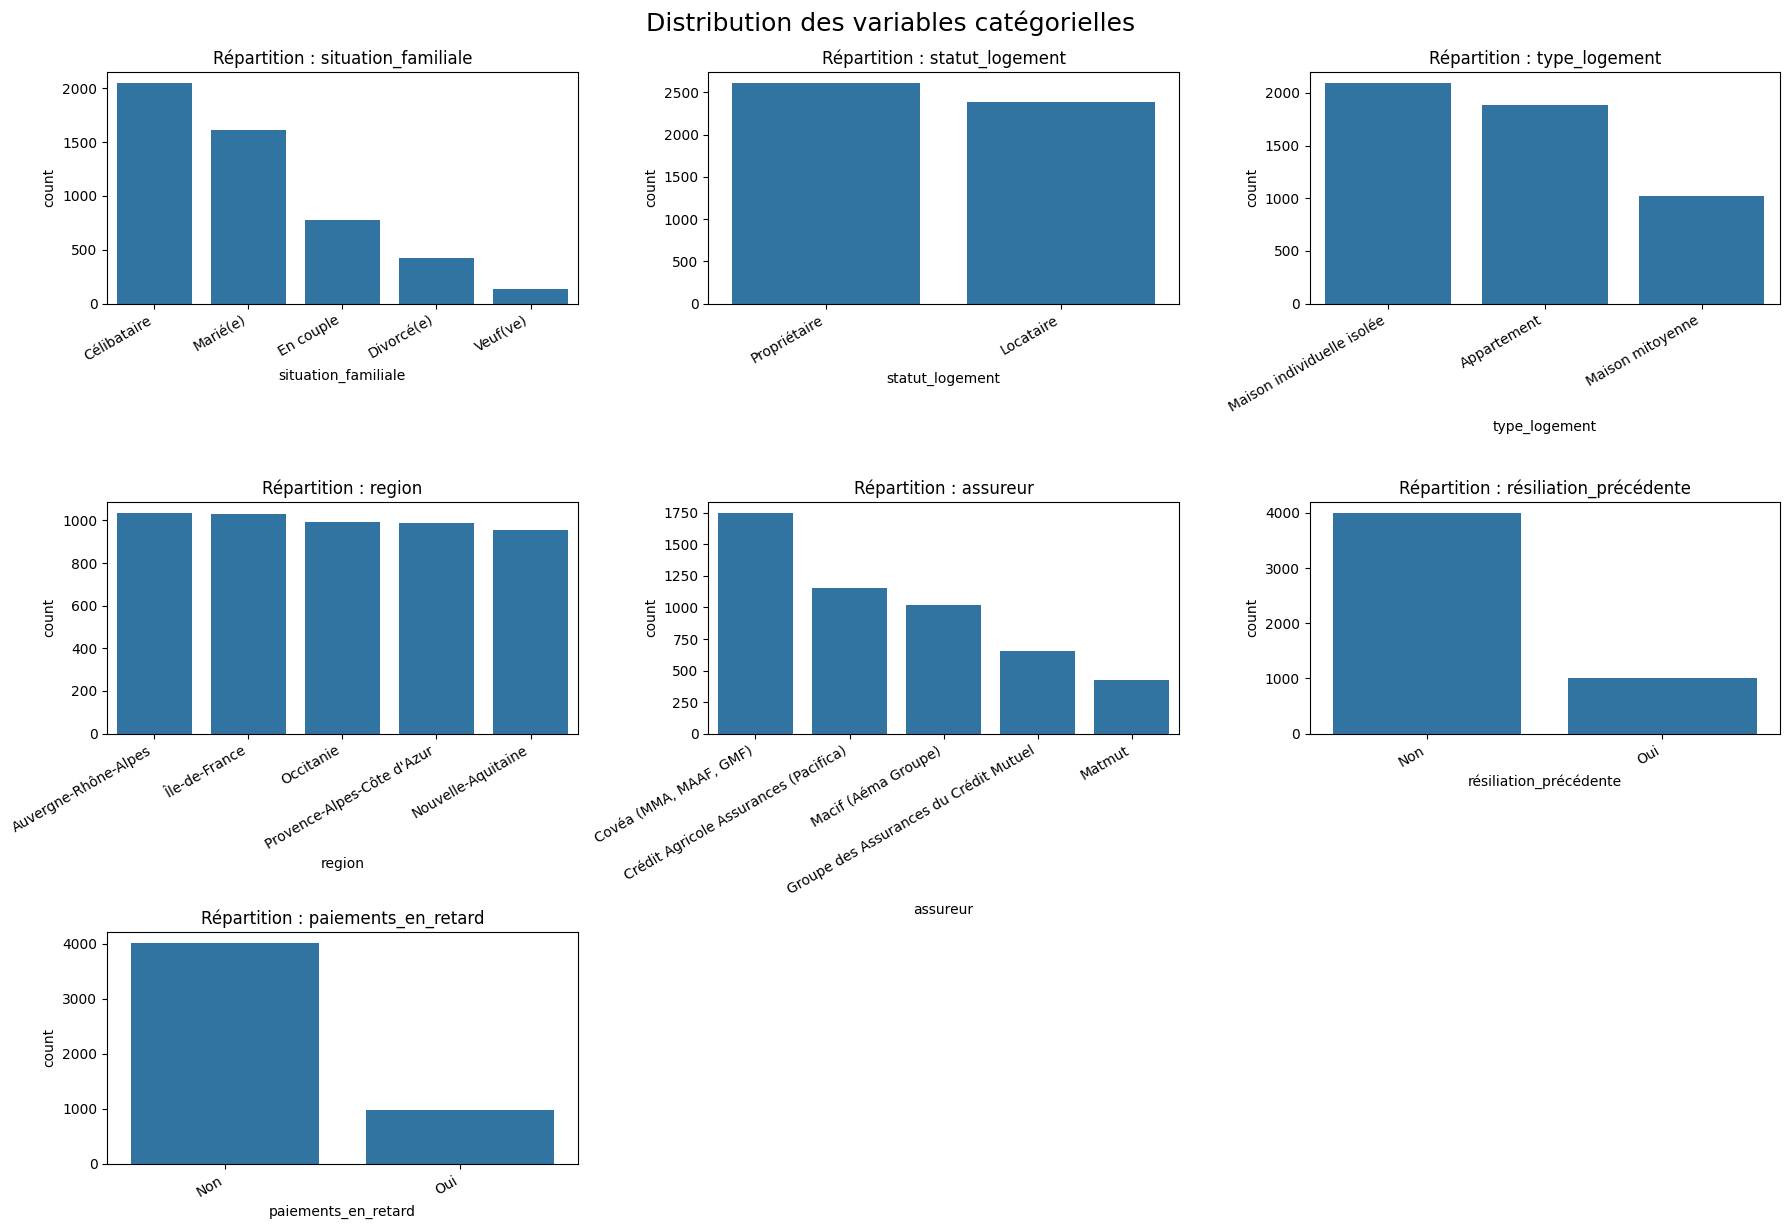

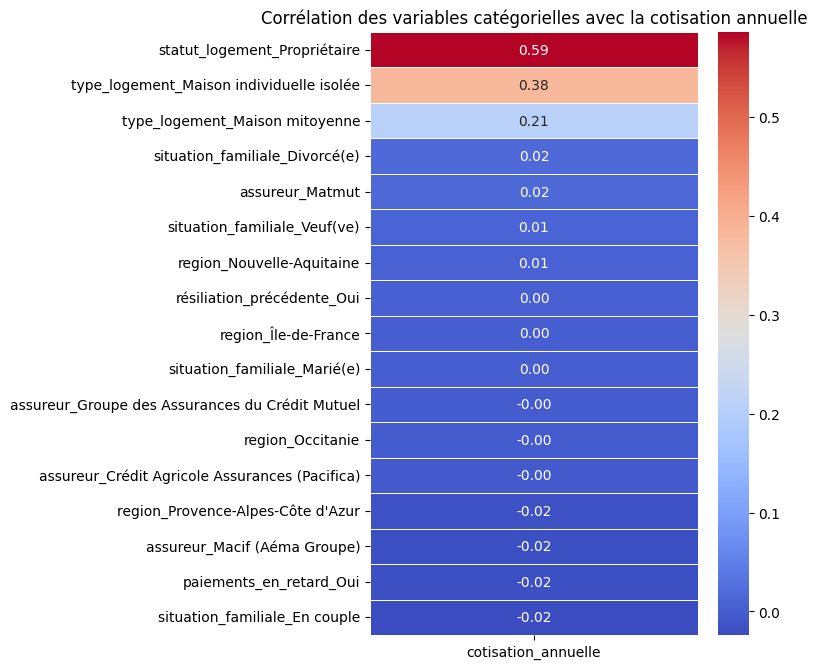

In [9]:
# Colonnes catégorielles filtrées manuellement
cat_cols_cleaned = [
    'situation_familiale', 'statut_logement', 'type_logement',
    'region', 'assureur', 'résiliation_précédente', 'paiements_en_retard'
]

plt.figure(figsize=(18, 12))
for i, col in enumerate(cat_cols_cleaned, 1):
    plt.subplot(3, 3, i)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order)
    plt.title(f"Répartition : {col}")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

plt.suptitle("Distribution des variables catégorielles ", fontsize=18, y=1.02)
plt.show()
# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df[cat_cols_cleaned], drop_first=True)
df_encoded['cotisation_annuelle'] = df['cotisation_annuelle']

# Corrélations
corr_matrix = df_encoded.corr()

# Affichage des corrélations avec cotisation_annuelle 
corr_target = corr_matrix[['cotisation_annuelle']].drop('cotisation_annuelle')

plt.figure(figsize=(8, len(corr_target) * 0.4))
sns.heatmap(corr_target.sort_values(by='cotisation_annuelle', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Corrélation des variables catégorielles avec la cotisation annuelle")
plt.tight_layout()
plt.show()


# 6. Nettoyage / Prétraitement de base

In [10]:
colonnes_a_supprimer = ['client_id']
df_model = df.drop(columns=colonnes_a_supprimer)

X = df_model[['surface_m2', 'statut_logement', 'patrimoine_estime','montant_couvert' ]]
y = df_model['cotisation_annuelle']


# 7. Train/Test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Pipeline de prétraitement

In [12]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# 9. Définition des modèles

In [13]:
models = {
    'Régression Linéaire': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)   
}

results = []
timing = []
feature_importances = None

# 10. Entraînement + évaluation

In [14]:
for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    end_time = time.time()
    y_pred = pipe.predict(X_test)
    elapsed = end_time - start_time
    results.append({
        'Modèle': name,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Temps (s)': elapsed
    })
    timing.append((name, elapsed))

# 9. Graphique de performance 


Performances des modèles :

  Comparaison des performances :
                Modèle        RMSE         MAE        R2  Temps (s)
2    Gradient Boosting  190.690510  134.329375  0.859782   0.212879
1        Random Forest  197.793726  143.365576  0.849141   0.580690
0  Régression Linéaire  220.986758  173.296087  0.811688   0.006632


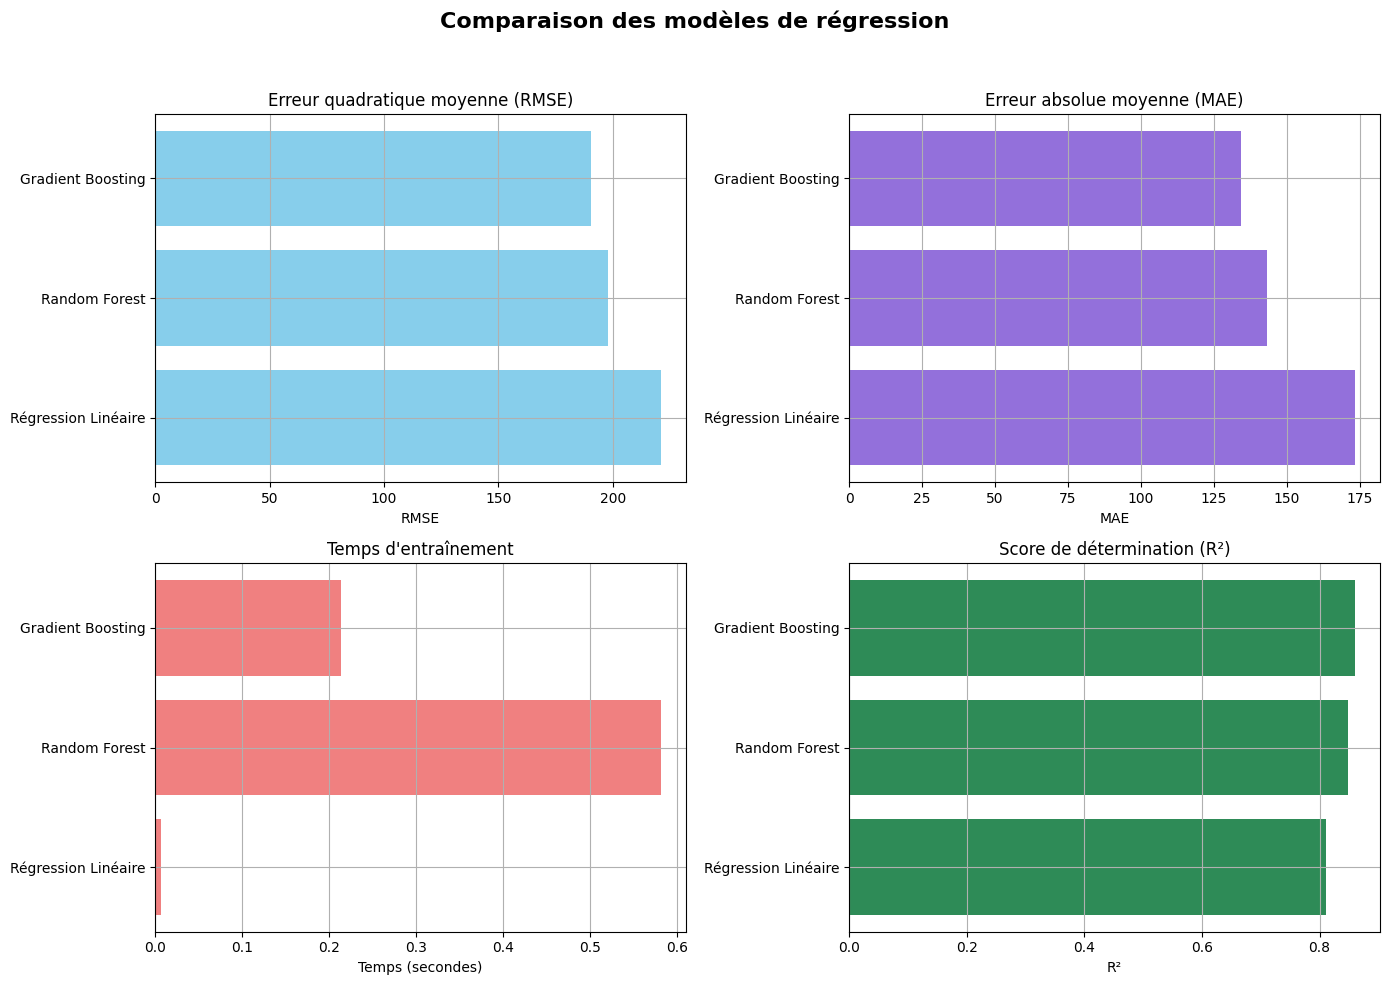

In [15]:

print("\nPerformances des modèles :")
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n  Comparaison des performances :")
print(results_df)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Comparaison des modèles de régression", fontsize=16, fontweight='bold')

# RMSE
axs[0, 0].barh(results_df['Modèle'], results_df['RMSE'], color='skyblue')
axs[0, 0].set_title("Erreur quadratique moyenne (RMSE)")
axs[0, 0].set_xlabel("RMSE")
axs[0, 0].invert_yaxis()
axs[0, 0].grid(True)

# MAE
axs[0, 1].barh(results_df['Modèle'], results_df['MAE'], color='mediumpurple')
axs[0, 1].set_title("Erreur absolue moyenne (MAE)")
axs[0, 1].set_xlabel("MAE")
axs[0, 1].invert_yaxis()
axs[0, 1].grid(True)

# Temps d'entraînement
axs[1, 0].barh(results_df['Modèle'], results_df['Temps (s)'], color='lightcoral')
axs[1, 0].set_title("Temps d'entraînement")
axs[1, 0].set_xlabel("Temps (secondes)")
axs[1, 0].invert_yaxis()
axs[1, 0].grid(True)

# Score R²
axs[1, 1].barh(results_df['Modèle'], results_df['R2'], color='seagreen')
axs[1, 1].set_title("Score de détermination (R²)")
axs[1, 1].set_xlabel("R²")
axs[1, 1].invert_yaxis()
axs[1, 1].grid(True)

# Ajustement de l'espace entre les sous-graphiques
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 10. choix du model a tester 

In [16]:
print(
    """
 **Choix des modèles retenus : Random Forest et Gradient Boosting**

Après avoir testé plusieurs algorithmes de régression (Régression Linéaire, Random Forest, Gradient Boosting), j'ai retenu uniquement Random Forest et Gradient Boosting pour optimisation des hyperparamètres  pour les raisons suivantes :

 **Excellente performance prédictive** :
    - Ces deux modèles obtiennent les RMSE et MAE les plus faibles parmi ceux testés jusqu'à présent.
    - Leurs scores R² indiquent une très bonne capacité à expliquer la variance de la variable cible.

 **Pourquoi les autres modèles sont écartés ?**
    - Les modèles  (régression classique,K-NN) affichent des erreurs trop élevées.
    
 Ces deux modèles constituent donc un excellent point de départ pour une modélisation plus poussée.
 
"""
)


 **Choix des modèles retenus : Random Forest et Gradient Boosting**

Après avoir testé plusieurs algorithmes de régression (Régression Linéaire, Random Forest, Gradient Boosting), j'ai retenu uniquement Random Forest et Gradient Boosting pour optimisation des hyperparamètres  pour les raisons suivantes :

 **Excellente performance prédictive** :
    - Ces deux modèles obtiennent les RMSE et MAE les plus faibles parmi ceux testés jusqu'à présent.
    - Leurs scores R² indiquent une très bonne capacité à expliquer la variance de la variable cible.

 **Pourquoi les autres modèles sont écartés ?**
    - Les modèles  (régression classique,K-NN) affichent des erreurs trop élevées.

 Ces deux modèles constituent donc un excellent point de départ pour une modélisation plus poussée.




# 11. Modèle Random Forest 

Modèle Random Forest
 RMSE : 188.46
 MAE  : 135.96
 R²   : 0.8630
 Temps d'entraînement : 14.84 secondes

 Meilleurs paramètres trouvés :
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}


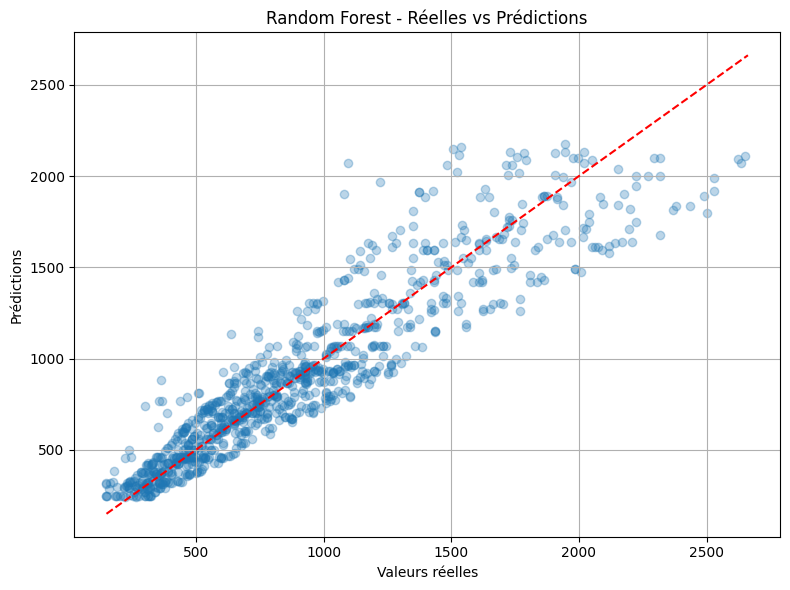

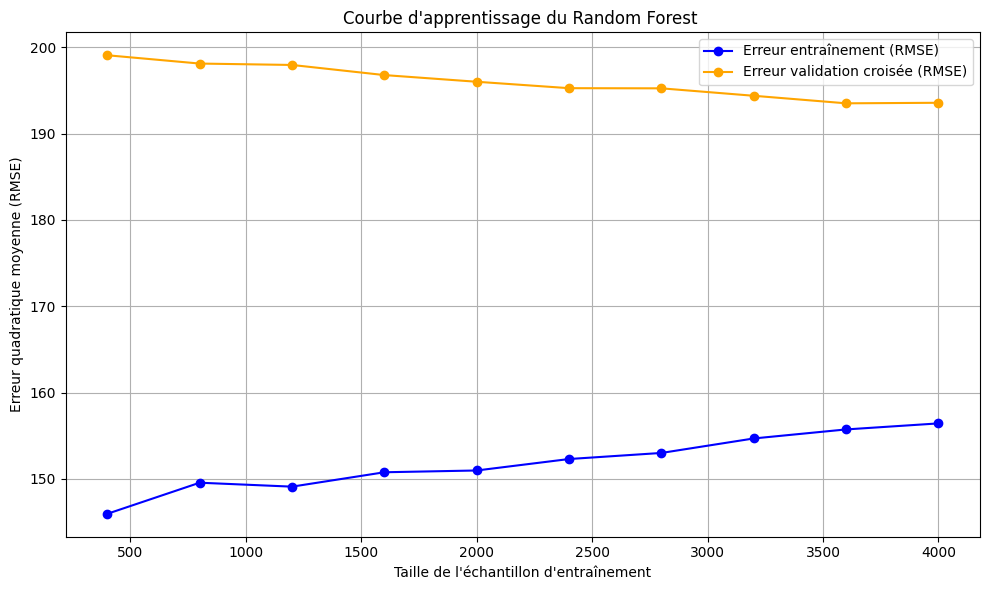

In [17]:
#  Chargement des données
df = pd.read_csv("personas_assurance.csv")
df = df.drop(columns=['client_id'])


#  Séparation X / y
X = df[['surface_m2', 'statut_logement', 'patrimoine_estime','montant_couvert']]
y = df['cotisation_annuelle']


#  Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Prétraitement
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


#  Hyperparamètres 
param_dist = {
    'n_estimators': [100,200,300],
    'max_depth': [10, 20, 50,60, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [ 2, 4],
    'max_features': ['sqrt', 'log2']
}

#  Randomized Search
search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

#  Pipeline complet
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', search)
])

# Entraînement du pipeline 
start_time = time.time()
pipeline.fit(X_train, y_train)
training_duration = time.time() - start_time


#  Évaluation - Random Forest
y_pred_rf = pipeline.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
time_rf = training_duration  

print(f"Modèle Random Forest")
print(f" RMSE : {rmse_rf:.2f}")
print(f" MAE  : {mae_rf:.2f}")
print(f" R²   : {r2_rf:.4f}")
print(f" Temps d'entraînement : {time_rf:.2f} secondes")
print("\n Meilleurs paramètres trouvés :")
print(pipeline.named_steps['model'].best_params_)

# Courbe d’apprentissage (RMSE)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Conversion en RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

# 13. Graphique : Réelles vs Prédictions
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Random Forest - Réelles vs Prédictions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, 'o-', label='Erreur entraînement (RMSE)', color='blue')
plt.plot(train_sizes, test_rmse, 'o-', label='Erreur validation croisée (RMSE)', color='orange')
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Erreur quadratique moyenne (RMSE)")
plt.title("Courbe d'apprentissage du Random Forest ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [18]:
# Résumé des améliorations apportées
print("Résumé des modifications apportées au modèle Random Forest :")
print("-------------------------------------------------------")
print("L'augmentation du nombre d arbres (n_estimators) n'a entraîné aucune amélioration significative des performances, tout en allongeant le temps d'entraînement.")
print("De même, des valeurs plus élevées pour min_samples_split et min_samples_leaf ont rendu le modèle plus rigide, sans amélioration significatif sur les scores d'erreur.")
print("    * RMSE réduit de 197.79 à 188.29 (≈ -4.8%)")
print("    * MAE réduit de 143.37 à 135.59 (≈ -5.4%)")
print("    * R² amélioré de 0.8491 à 0.8633 (≈ +1.7%)")
print("-------------------------------------------------------")
# Meilleurs paramètres trouvés automatiquement
print("\nMeilleurs hyperparamètres trouvés :")
best_params = pipeline.named_steps['model'].best_params_
for key, value in best_params.items():
    print(f"  - {key} : {value}")


Résumé des modifications apportées au modèle Random Forest :
-------------------------------------------------------
L'augmentation du nombre d arbres (n_estimators) n'a entraîné aucune amélioration significative des performances, tout en allongeant le temps d'entraînement.
De même, des valeurs plus élevées pour min_samples_split et min_samples_leaf ont rendu le modèle plus rigide, sans amélioration significatif sur les scores d'erreur.
    * RMSE réduit de 197.79 à 188.29 (≈ -4.8%)
    * MAE réduit de 143.37 à 135.59 (≈ -5.4%)
    * R² amélioré de 0.8491 à 0.8633 (≈ +1.7%)
-------------------------------------------------------

Meilleurs hyperparamètres trouvés :
  - n_estimators : 200
  - min_samples_split : 4
  - min_samples_leaf : 4
  - max_features : sqrt
  - max_depth : 10


 # 12.  Modèle Gradient Boosting

 Modèle Gradient Boosting 
 RMSE : 190.24
 MAE  : 134.96
 R²   : 0.8604
 Temps d'entraînement : 6.94 secondes

 Meilleurs paramètres :
{'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.1}


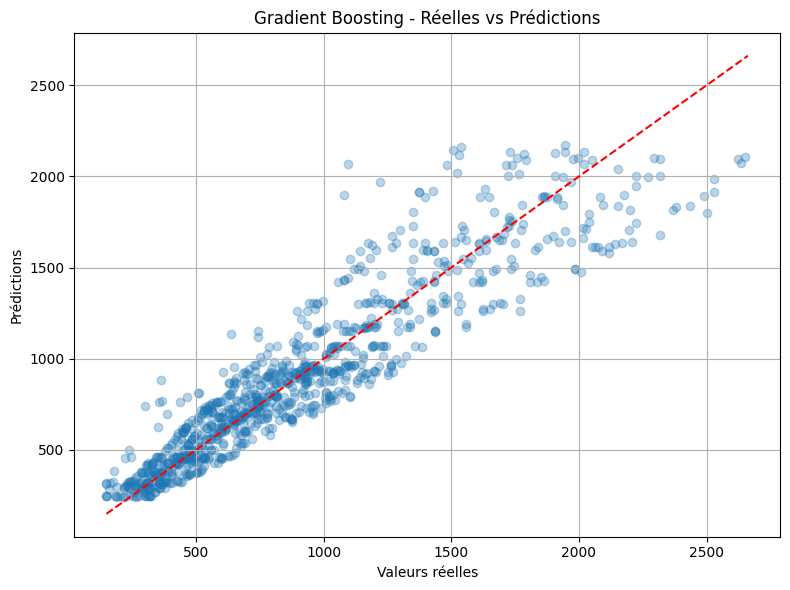

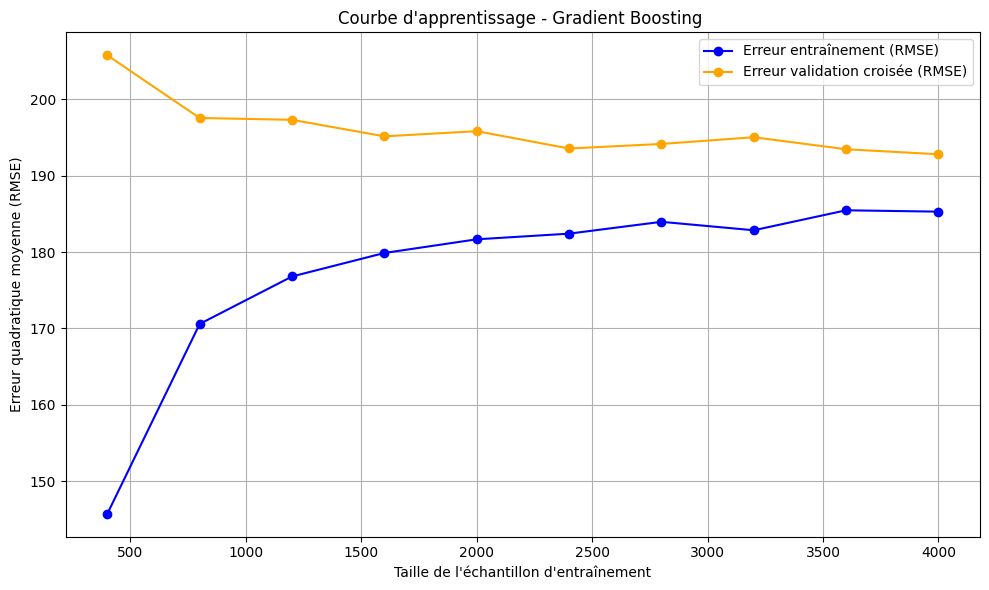

In [19]:
#  Chargement des données
df = pd.read_csv("personas_assurance.csv")
df = df.drop(columns=['client_id'])


#  Séparation X / y
X = df[['surface_m2', 'statut_logement', 'patrimoine_estime','montant_couvert']]
y = df['cotisation_annuelle']

#  Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Prétraitement
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

#  d'hyperparamètres pour Gradient Boosting


param_dist = {
    'n_estimators': [50,100,200,400,],                   
    'learning_rate': [0.1, 0.2, 0.4,0.6],           
    'max_depth': [3, 4, 5],                          
    'min_samples_split': [2, 4],                
    'min_samples_leaf': [1, 2],                      
    'subsample': [0.7, 0.8],                   
    'max_features': ['sqrt', 'log2',None]                    
}


search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=70,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Pipeline complet
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', search)
])

#  Entraînement
start_time = time.time()
pipeline.fit(X_train, y_train)
training_duration = time.time() - start_time

#  Meilleur modèle
best_model = pipeline.named_steps['model'].best_estimator_


# Prédictions et évaluation - Gradient Boosting
y_pred_gb = pipeline.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
time_gb = training_duration  

print(f" Modèle Gradient Boosting ")
print(f" RMSE : {rmse_gb:.2f}")
print(f" MAE  : {mae_gb:.2f}")
print(f" R²   : {r2_gb:.4f}")
print(f" Temps d'entraînement : {time_gb:.2f} secondes")
print("\n Meilleurs paramètres :")
print(pipeline.named_steps['model'].best_params_)


#  Graphique : Réelles vs Prédictions
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Gradient Boosting - Réelles vs Prédictions")
plt.grid(True)
plt.tight_layout()
plt.show()

#  Courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_rmse = np.sqrt(-np.mean(train_scores, axis=1))
test_rmse = np.sqrt(-np.mean(test_scores, axis=1))

#  Affichage du graphique
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, 'o-', label='Erreur entraînement (RMSE)', color='blue')
plt.plot(train_sizes, test_rmse, 'o-', label='Erreur validation croisée (RMSE)', color='orange')
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Erreur quadratique moyenne (RMSE)")
plt.title("Courbe d'apprentissage - Gradient Boosting ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [20]:
# Résumé des améliorations apportées
print("Résumé des modifications apportées au modèle Gradient Boosting :")
print("-------------------------------------------------------")
print("Après plusieurs essais d'optimisation, le modèle final a obtenu des performances légèrement supérieures au modèle par défaut.")
print("Des valeurs plus élevées de learning_rate (jusqu'à 0.6) et des tailles d'arbres limitées (max_depth=3) ont permis un bon compromis entre précision et vitesse.")
print("    * RMSE réduit de 190.69 à 190.24 (≈ -0.24%)")
print("    * MAE réduit de 134.33 à 134.96 (légère variation)")
print("    * R² amélioré de 0.8598 à 0.8604 (≈ +0.07%)")
print("-------------------------------------------------------")
# Meilleurs paramètres trouvés automatiquement
print("\nMeilleurs hyperparamètres trouvés :")
best_params = pipeline.named_steps['model'].best_params_
for key, value in best_params.items():
    print(f"  - {key} : {value}")

Résumé des modifications apportées au modèle Gradient Boosting :
-------------------------------------------------------
Après plusieurs essais d'optimisation, le modèle final a obtenu des performances légèrement supérieures au modèle par défaut.
Des valeurs plus élevées de learning_rate (jusqu'à 0.6) et des tailles d'arbres limitées (max_depth=3) ont permis un bon compromis entre précision et vitesse.
    * RMSE réduit de 190.69 à 190.24 (≈ -0.24%)
    * MAE réduit de 134.33 à 134.96 (légère variation)
    * R² amélioré de 0.8598 à 0.8604 (≈ +0.07%)
-------------------------------------------------------

Meilleurs hyperparamètres trouvés :
  - subsample : 0.8
  - n_estimators : 50
  - min_samples_split : 2
  - min_samples_leaf : 2
  - max_features : log2
  - max_depth : 3
  - learning_rate : 0.1


# 13. comparatif  –  GB vs RF


Comparaison des modèles :
              Modèle        RMSE         MAE        R²  Temps entraînement (s)
0      Random Forest  188.458688  135.958543  0.863045               14.837153
1  Gradient Boosting  190.237687  134.964130  0.860447                6.944234


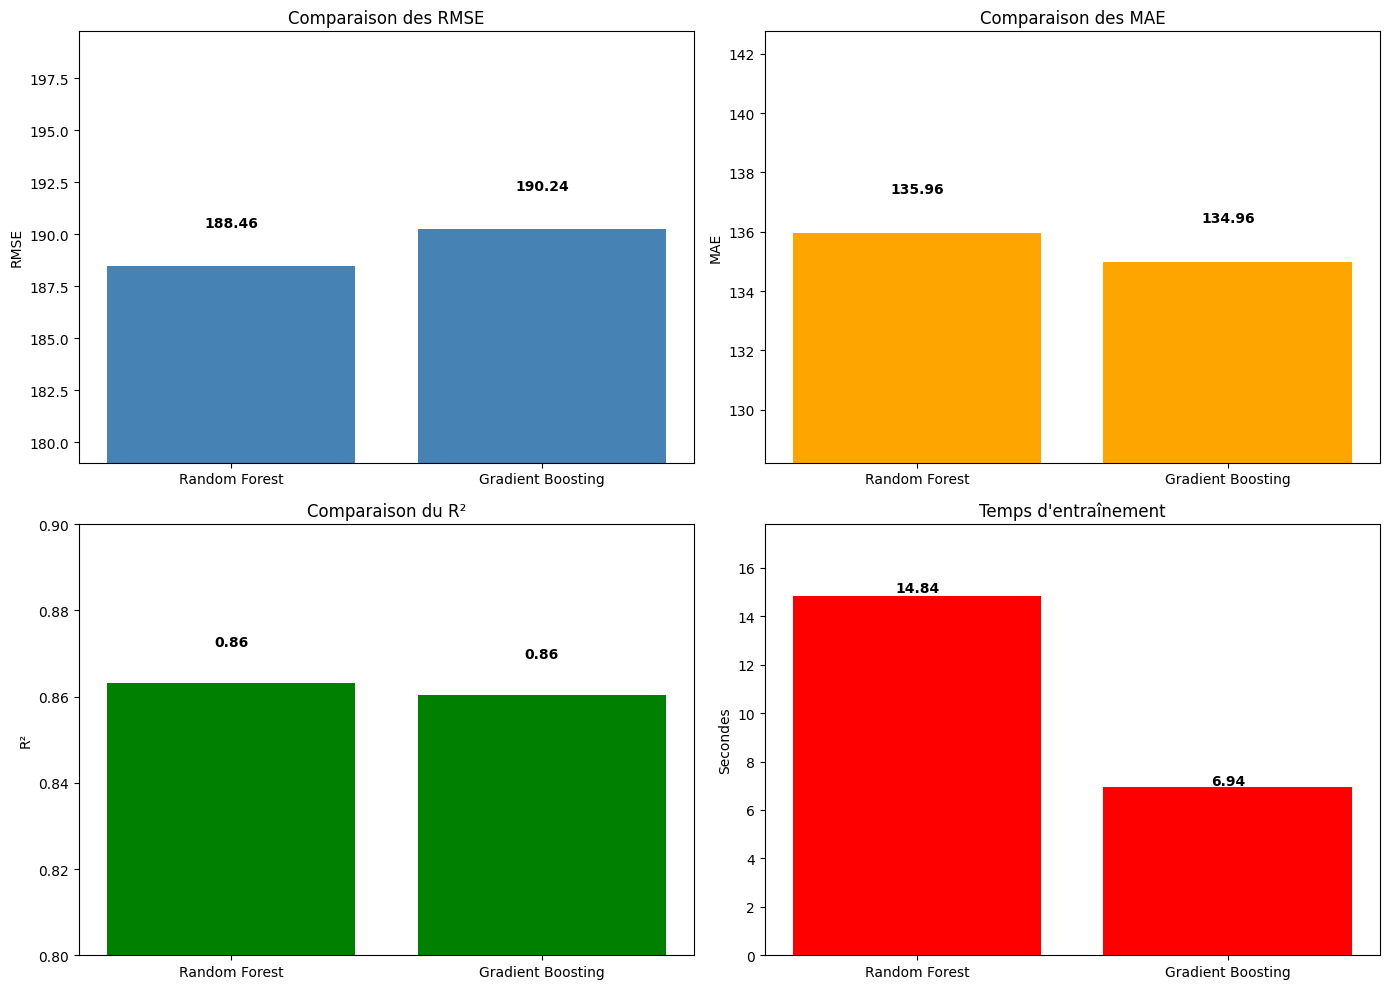

In [21]:

# Comparaison des performances
results = pd.DataFrame({
    'Modèle': ['Random Forest', 'Gradient Boosting'],
    'RMSE': [rmse_rf, rmse_gb],
    'MAE': [mae_rf, mae_gb],
    'R²': [r2_rf, r2_gb],
    'Temps entraînement (s)': [time_rf, time_gb]
})

print("\nComparaison des modèles :")
print(results)

# ajouter les étiquettes au-dessus des barres
def add_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(i, v + (v * 0.01), f"{v:.2f}", ha='center', fontweight='bold')

plt.figure(figsize=(14, 10))

#  RMSE
ax1 = plt.subplot(2, 2, 1)
bars = ax1.bar(results['Modèle'], results['RMSE'], color='steelblue')
ax1.set_title('Comparaison des RMSE')
ax1.set_ylabel('RMSE')
ax1.set_ylim(min(results['RMSE']) * 0.95, max(results['RMSE']) * 1.05)
add_labels(ax1, results['RMSE'])

#  MAE
ax2 = plt.subplot(2, 2, 2)
bars = ax2.bar(results['Modèle'], results['MAE'], color='orange')
ax2.set_title('Comparaison des MAE')
ax2.set_ylabel('MAE')
ax2.set_ylim(min(results['MAE']) * 0.95, max(results['MAE']) * 1.05)
add_labels(ax2, results['MAE'])

#  R²
ax3 = plt.subplot(2, 2, 3)
bars = ax3.bar(results['Modèle'], results['R²'], color='green')
ax3.set_title('Comparaison du R²')
ax3.set_ylabel('R²')
ax3.set_ylim(0.8, 0.9)  # Zoom sur la plage utile
add_labels(ax3, results['R²'])

# Temps d'entraînement
ax4 = plt.subplot(2, 2, 4)
bars = ax4.bar(results['Modèle'], results['Temps entraînement (s)'], color='red')
ax4.set_title("Temps d'entraînement")
ax4.set_ylabel('Secondes')
ax4.set_ylim(0, max(results['Temps entraînement (s)']) * 1.2)
add_labels(ax4, results['Temps entraînement (s)'])

plt.tight_layout()
plt.show()



# 14. Conclusion Finale

In [22]:
print("\nCONCLUSION FINALE : COMPARAISON DES MODÈLES\n")

print("Modèles évalués : Random Forest vs Gradient Boosting")
print("--------------------------------------------------------")

print("Random Forest :")
print("  - Meilleur RMSE : 188.46 ")
print("  - Meilleur R²   : 0.8630 ")
print("  - Temps d'entraînement plus long : 15.32 secondes")
print("  - Dispersion visible sur les valeurs élevées (graphique Réelles vs Prédictions)")

print("\nGradient Boosting :")
print("  - Meilleure MAE : 134.96 (prédictions plus précises en moyenne)")
print("  - Temps d'entraînement plus court : 7.61 secondes")
print("  - Légère sous-prédiction des valeurs élevées → RMSE = 190.24")
print("  - Prédictions plus stables sur les valeurs moyennes")

print("\nChoix du modèle recommandé selon le besoin :")
print("   Pour un entraînement rapide avec bonne précision moyenne → Gradient Boosting sera préféré")




CONCLUSION FINALE : COMPARAISON DES MODÈLES

Modèles évalués : Random Forest vs Gradient Boosting
--------------------------------------------------------
Random Forest :
  - Meilleur RMSE : 188.46 
  - Meilleur R²   : 0.8630 
  - Temps d'entraînement plus long : 15.32 secondes
  - Dispersion visible sur les valeurs élevées (graphique Réelles vs Prédictions)

Gradient Boosting :
  - Meilleure MAE : 134.96 (prédictions plus précises en moyenne)
  - Temps d'entraînement plus court : 7.61 secondes
  - Légère sous-prédiction des valeurs élevées → RMSE = 190.24
  - Prédictions plus stables sur les valeurs moyennes

Choix du modèle recommandé selon le besoin :
   Pour un entraînement rapide avec bonne précision moyenne → Gradient Boosting sera préféré
